In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image


In [2]:
class HairRemovalDataset(Dataset):
    def __init__(self, image_dir, clean_dir, transform=None):
        self.image_dir = image_dir
        self.clean_dir = clean_dir
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        hair_img_path = os.path.join(self.image_dir, self.image_list[idx])
        clean_img_path = os.path.join(self.clean_dir, self.image_list[idx])  # same name

        hair_img = Image.open(hair_img_path).convert('RGB').resize((256, 256))
        clean_img = Image.open(clean_img_path).convert('RGB').resize((256, 256))

        if self.transform:
            hair_img = self.transform(hair_img)
            clean_img = self.transform(clean_img)

        return hair_img, clean_img


In [3]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        # 下采样
        self.down1 = self.conv_block(in_channels, features)       # 3 → 64
        self.down2 = self.conv_block(features, features*2)        # 64 → 128
        self.down3 = self.conv_block(features*2, features*4)      # 128 → 256
        self.down4 = self.conv_block(features*4, features*8)      # 256 → 512
        self.bottleneck = self.conv_block(features*8, features*8) # 512 → 512

        # 上采样
        self.up4 = self.up_block(features*8, features*8)           # 512 → 512
        self.up3 = self.up_block(features*8*2, features*4)         # 1024 → 256
        self.up2 = self.up_block(features*4*2, features*2)         # 512 → 128
        self.up1 = self.up_block(features*2*2, features)           # 256 → 64

        self.final_up = nn.ConvTranspose2d(features*2, out_channels, kernel_size=2, stride=2)
        self.final_act = nn.Tanh()

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        d1 = self.down1(x)  # 64
        d2 = self.down2(d1) # 128
        d3 = self.down3(d2) # 256
        d4 = self.down4(d3) # 512
        bottleneck = self.bottleneck(d4)  # 512

        up4 = self.up4(bottleneck)        # 512
        up3 = self.up3(torch.cat([up4, d4], dim=1))  # 512 + 512 = 1024
        up2 = self.up2(torch.cat([up3, d3], dim=1))  # 256 + 256
        up1 = self.up1(torch.cat([up2, d2], dim=1))  # 128 + 128
        out = self.final_up(torch.cat([up1, d1], dim=1))  # 64 + 64 → out

        return self.final_act(out)


In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=6):
        super().__init__()
        def block(in_c, out_c, stride):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, stride, 1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            block(in_channels, 64, 2),
            block(64, 128, 2),
            block(128, 256, 2),
            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = HairRemovalDataset(
    image_dir='/root/autodl-fs/skin_hair_dataset/alignment/photo with hair',
    clean_dir='/root/autodl-fs/skin_hair_dataset/alignment/oryginal',
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

opt_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

# Training Loop
for epoch in range(40):
    g_loss_total, d_loss_total = 0, 0
    for hair_img, clean_img in tqdm(dataloader):
        hair_img, clean_img = hair_img.to(device), clean_img.to(device)
        fake_clean = generator(hair_img)

        # Train Discriminator
        D_real = discriminator(hair_img, clean_img)
        D_fake = discriminator(hair_img, fake_clean.detach())

        real_label = torch.ones_like(D_real)
        fake_label = torch.zeros_like(D_fake)

        D_loss_real = criterion_GAN(D_real, real_label)
        D_loss_fake = criterion_GAN(D_fake, fake_label)
        D_loss = (D_loss_real + D_loss_fake) / 2

        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()

        # Train Generator
        D_fake = discriminator(hair_img, fake_clean)
        G_adv = criterion_GAN(D_fake, real_label)
        G_l1 = criterion_L1(fake_clean, clean_img)
        G_loss = G_adv + 100 * G_l1  # L1 loss加权

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

        g_loss_total += G_loss.item()
        d_loss_total += D_loss.item()

    print(f"Epoch {epoch+1} | G Loss: {g_loss_total/len(dataloader):.4f} | D Loss: {d_loss_total/len(dataloader):.4f}")
    torch.save(generator.state_dict(), f"generator_epoch{epoch+1}.pth")


100%|██████████| 19/19 [00:09<00:00,  2.06it/s]


Epoch 1 | G Loss: 42.5118 | D Loss: 0.6329


100%|██████████| 19/19 [00:05<00:00,  3.24it/s]


Epoch 2 | G Loss: 27.3170 | D Loss: 0.4589


100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch 3 | G Loss: 23.5540 | D Loss: 0.2885


100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch 4 | G Loss: 20.0945 | D Loss: 0.2813


100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


Epoch 5 | G Loss: 17.5781 | D Loss: 0.3698


100%|██████████| 19/19 [00:05<00:00,  3.29it/s]


Epoch 6 | G Loss: 17.0767 | D Loss: 0.3286


100%|██████████| 19/19 [00:05<00:00,  3.29it/s]


Epoch 7 | G Loss: 16.1556 | D Loss: 0.3475


100%|██████████| 19/19 [00:05<00:00,  3.34it/s]


Epoch 8 | G Loss: 15.7601 | D Loss: 0.2605


100%|██████████| 19/19 [00:05<00:00,  3.31it/s]


Epoch 9 | G Loss: 15.5721 | D Loss: 0.2768


100%|██████████| 19/19 [00:05<00:00,  3.23it/s]


Epoch 10 | G Loss: 14.6335 | D Loss: 0.2058


100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Epoch 11 | G Loss: 16.1257 | D Loss: 0.1655


100%|██████████| 19/19 [00:05<00:00,  3.25it/s]


Epoch 12 | G Loss: 15.3455 | D Loss: 0.1155


100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


Epoch 13 | G Loss: 16.0426 | D Loss: 0.1039


100%|██████████| 19/19 [00:05<00:00,  3.27it/s]


Epoch 14 | G Loss: 15.2813 | D Loss: 0.1090


100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Epoch 15 | G Loss: 15.1324 | D Loss: 0.0582


100%|██████████| 19/19 [00:05<00:00,  3.34it/s]


Epoch 16 | G Loss: 15.4226 | D Loss: 0.0644


100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Epoch 17 | G Loss: 14.8260 | D Loss: 0.2387


100%|██████████| 19/19 [00:05<00:00,  3.22it/s]


Epoch 18 | G Loss: 13.2070 | D Loss: 0.7233


100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch 19 | G Loss: 12.9620 | D Loss: 0.3495


100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


Epoch 20 | G Loss: 13.6327 | D Loss: 0.2967


100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch 21 | G Loss: 13.4586 | D Loss: 0.3674


100%|██████████| 19/19 [00:05<00:00,  3.25it/s]


Epoch 22 | G Loss: 13.7901 | D Loss: 0.1604


100%|██████████| 19/19 [00:05<00:00,  3.32it/s]


Epoch 23 | G Loss: 14.9807 | D Loss: 0.0730


100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Epoch 24 | G Loss: 15.7052 | D Loss: 0.0695


100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


Epoch 25 | G Loss: 14.8329 | D Loss: 0.2656


100%|██████████| 19/19 [00:05<00:00,  3.25it/s]


Epoch 26 | G Loss: 14.1559 | D Loss: 0.4952


100%|██████████| 19/19 [00:05<00:00,  3.25it/s]


Epoch 27 | G Loss: 14.0325 | D Loss: 0.2046


100%|██████████| 19/19 [00:05<00:00,  3.18it/s]


Epoch 28 | G Loss: 15.3488 | D Loss: 0.0600


100%|██████████| 19/19 [00:05<00:00,  3.22it/s]


Epoch 29 | G Loss: 14.2787 | D Loss: 0.0685


100%|██████████| 19/19 [00:05<00:00,  3.23it/s]


Epoch 30 | G Loss: 15.8462 | D Loss: 0.0802


100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Epoch 31 | G Loss: 15.7631 | D Loss: 0.0339


100%|██████████| 19/19 [00:05<00:00,  3.31it/s]


Epoch 32 | G Loss: 15.5403 | D Loss: 0.1263


100%|██████████| 19/19 [00:05<00:00,  3.29it/s]


Epoch 33 | G Loss: 15.4634 | D Loss: 0.5298


100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


Epoch 34 | G Loss: 13.9743 | D Loss: 0.1591


100%|██████████| 19/19 [00:05<00:00,  3.27it/s]


Epoch 35 | G Loss: 15.4449 | D Loss: 0.0662


100%|██████████| 19/19 [00:05<00:00,  3.25it/s]


Epoch 36 | G Loss: 14.9235 | D Loss: 0.0368


100%|██████████| 19/19 [00:05<00:00,  3.20it/s]


Epoch 37 | G Loss: 15.6095 | D Loss: 0.0284


100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


Epoch 38 | G Loss: 14.2219 | D Loss: 0.1427


100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


Epoch 39 | G Loss: 14.8168 | D Loss: 0.3689


100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Epoch 40 | G Loss: 13.9038 | D Loss: 0.1209


/tmp/ipykernel_1722/290376399.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_epoch40.pth"))


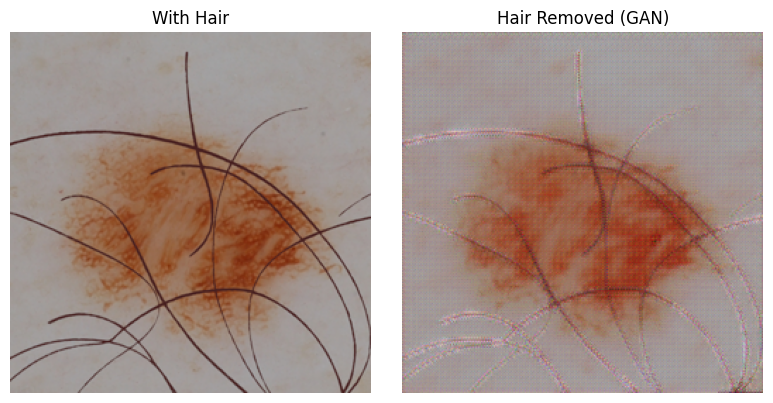

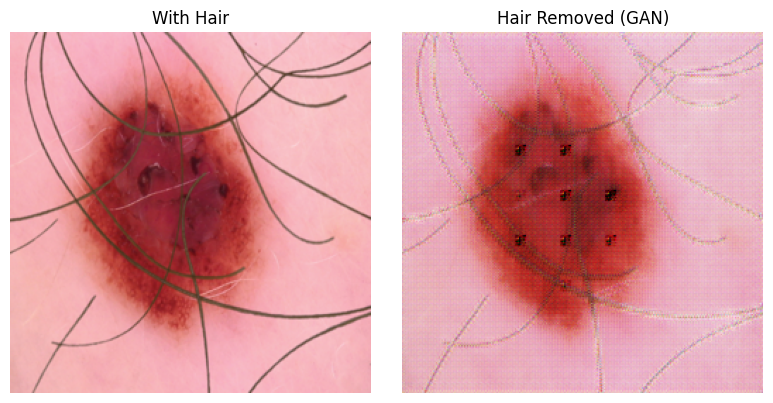

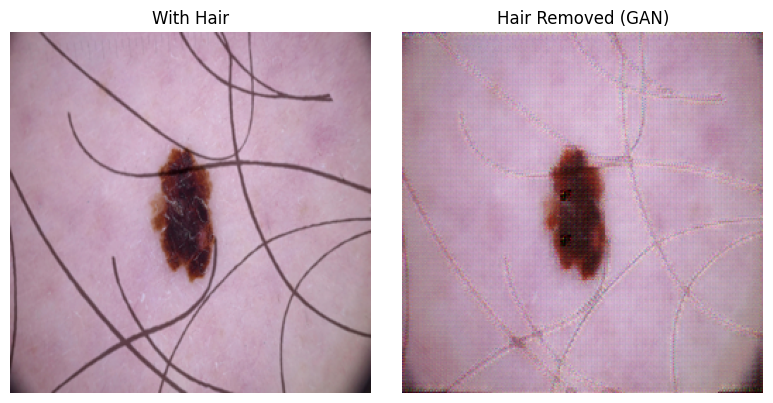

In [5]:
generator.load_state_dict(torch.load("generator_epoch40.pth"))
generator.eval()

def remove_hair(image_path, save_path=None):
    image = Image.open(image_path).convert('RGB').resize((256, 256))
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = generator(input_tensor).squeeze(0).cpu()
    output = (output * 0.5 + 0.5).clamp(0, 1)  # 反归一化
    output_image = transforms.ToPILImage()(output)
    if save_path:
        output_image.save(save_path)
    return image, output_image

test_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
image_list = ["ISIC2019_0000461.jpg", "ISIC2019_0031696.jpg", "ISIC2019_0028326.jpg"]

for img_name in image_list:
    ori, out = remove_hair(os.path.join(test_dir, img_name))
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1); plt.imshow(ori); plt.title("With Hair"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(out); plt.title("Hair Removed (GAN)"); plt.axis('off')
    plt.tight_layout(); plt.show()


In [8]:
from skimage.metrics import structural_similarity

def evaluate_image_quality(original_pil, inpainted_pil):
    original = np.array(original_pil.resize((256, 256))).astype(np.float32) / 255.0
    inpainted = np.array(inpainted_pil.resize((256, 256))).astype(np.float32) / 255.0

    mse = mean_squared_error(original, inpainted)
    psnr = peak_signal_noise_ratio(original, inpainted, data_range=1.0)
    
    # ✅ 修复关键：设置 channel_axis=2（新版参数，取代 multichannel）
    ssim = structural_similarity(original, inpainted, channel_axis=2, data_range=1.0)

    original_uint8 = (original * 255).astype(np.uint8)
    inpainted_uint8 = (inpainted * 255).astype(np.uint8)
    uqi_value = uqi(original_uint8, inpainted_uint8)

    return mse, psnr, ssim, uqi_value


In [9]:
image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
gt_dir = "/root/autodl-fs/skin_hair_dataset/alignment/oryginal"
image_names = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

mse_list, psnr_list, ssim_list, uqi_list = [], [], [], []

for img_name in tqdm(image_names):
    input_path = os.path.join(image_dir, img_name)
    gt_path = os.path.join(gt_dir, img_name)

    if not os.path.exists(gt_path):
        continue

    original_pil = Image.open(gt_path).convert("RGB").resize((256, 256))
    _, inpainted_pil = remove_hair(input_path)

    mse, psnr, ssim, uqi_val = evaluate_image_quality(original_pil, inpainted_pil)

    mse_list.append(mse)
    psnr_list.append(psnr)
    ssim_list.append(ssim)
    uqi_list.append(uqi_val)

avg_mse = np.mean(mse_list)
avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)
avg_uqi = np.mean(uqi_list)

print("\n===== 平均图像质量指标（GAN方法） =====")
print(f"MSE   : {avg_mse:.6f}")
print(f"PSNR  : {avg_psnr:.2f} dB")
print(f"SSIM  : {avg_ssim:.4f}")
print(f"UQI   : {avg_uqi:.4f}")


100%|██████████| 76/76 [00:07<00:00, 10.03it/s]


===== 平均图像质量指标（GAN方法） =====
MSE   : 0.002110
PSNR  : 27.04 dB
SSIM  : 0.6499
UQI   : 0.9895
